<a href="https://colab.research.google.com/github/ds4geo/ds4geo/blob/master/WS%202020%20Course%20Notes/Session%209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Session 9

Supervised ML and Deep learning

# Introduction to Supervised Machine Learning
* Learning classification or regression from data with labels
* aim to learn general rules which can be applied on other data
* many algorithms are black boxes - the "rules" are difficult or impossible to know or understand

* examples

youtube CGP grey

# Introduction to rock geochem database

* Can we use ML to predict the rock types based on the bulk chemistry?
* Provided data already subset of data:
 * top 10 rock types only
 * with major element data
 

# Excercise - load and analyse rock geochem data

* load data
* some simple viz
* PCA of data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dat = pd.read_csv("https://github.com/ds4geo/ds4geo/blob/master/data/unordered/gwrgdb_maj_ele.csv?raw=true")

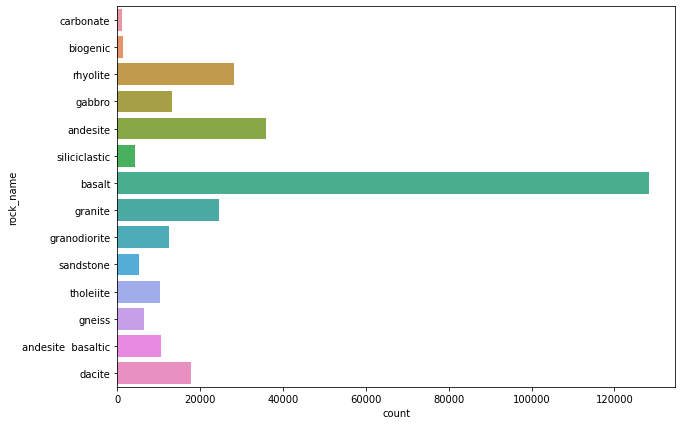

In [36]:
# dat.rock_name.value_counts()
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=dat, y="rock_name")

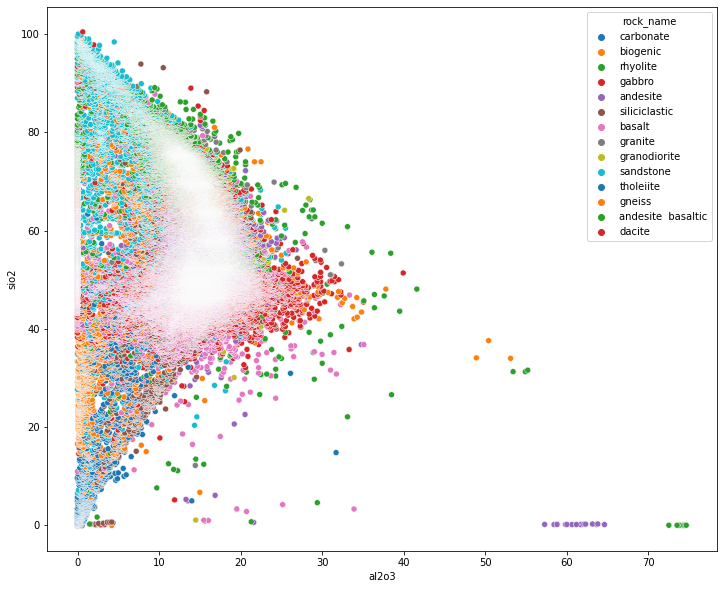

In [37]:
fig, ax = plt.subplots(figsize=(12,10))
sns.scatterplot(data=dat, x="al2o3", y="sio2", hue="rock_name", ax=ax, palette="tab10")

In [3]:
# We'll want to standardise
from sklearn.preprocessing import StandardScaler

In [39]:
dat

,rock_name,sio2,tio2,al2o3,cr2o3,fe2o3,feo,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,caco3,mgco3
0,carbonate,-0.133058,0.004258,0.040159,0.0,0.080270,0.00,0.491735,56.256725,0.001645,0.0,0.004645,0.025499,0.027725,0.000000,0.0,0
1,carbonate,-0.125000,0.009961,0.237194,0.0,0.150941,0.00,0.711252,55.468255,0.008428,0.0,-0.030101,0.005692,0.252736,0.033822,0.0,0
2,carbonate,-0.074878,0.004110,0.017141,0.0,0.196467,0.00,0.422455,56.301081,0.001804,0.0,0.008370,0.026964,0.022554,0.000000,0.0,0
3,carbonate,-0.072379,0.004258,0.012973,0.0,0.066819,0.00,0.781940,55.908111,0.000000,0.0,0.001252,0.033660,0.036715,0.000000,0.0,0
4,carbonate,-0.041508,0.004052,0.017542,0.0,0.070118,0.00,0.438004,56.313090,0.001038,0.0,0.012650,0.041112,0.025843,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300204,basalt,99.600000,0.030000,0.200000,0.0,0.000000,0.04,0.000000,0.000000,0.000000,0.0,0.020000,0.000000,0.000000,0.000000,0.0,0
300205,sandstone,99.600000,0.000000,0.000000,0.0,0.560000,0.21,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0
300206,sandstone,99.800000,0.040000,0.440000,0.0,0.000000,0.00,0.050000,0.110000,0.000000,0.0,0.000000,0.020000,0.000000,0.030000,0.0,0
300207,sandstone,99.990000,0.010000,0.100000,0.0,0.000000,0.00,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0


In [4]:
# Standardize
rdat = dat.iloc[:,1:]
sdat = StandardScaler().fit_transform(X=rdat)
sdat = pd.DataFrame(sdat, index=rdat.index, columns=rdat.columns)
sdat

,sio2,tio2,al2o3,cr2o3,fe2o3,feo,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,caco3,mgco3
0,-5.263409,-1.202817,-4.369917,-0.023153,-0.482811,-0.728177,-1.144038,9.029833,-0.324024,-0.005566,-0.996835,-2.400019,22.297611,-0.347074,-0.045236,0.0
1,-5.262670,-1.196729,-4.310732,-0.023153,-0.461181,-0.728177,-1.082226,8.884681,-0.308656,-0.005566,-1.016681,-2.416301,203.398980,-0.294095,-0.045236,0.0
2,-5.258067,-1.202975,-4.376831,-0.023153,-0.447248,-0.728177,-1.163547,9.037999,-0.323664,-0.005566,-0.994708,-2.398814,18.135827,-0.347074,-0.045236,0.0
3,-5.257838,-1.202818,-4.378083,-0.023153,-0.486928,-0.728177,-1.062321,8.965656,-0.327752,-0.005566,-0.998773,-2.393310,29.533851,-0.347074,-0.045236,0.0
4,-5.255003,-1.203037,-4.376710,-0.023153,-0.485918,-0.728177,-1.159168,9.040209,-0.325400,-0.005566,-0.992263,-2.387184,20.783616,-0.347074,-0.045236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300204,3.894203,-1.175336,-4.321904,-0.023153,-0.507378,-0.718464,-1.282504,-1.326648,-0.327752,-0.005566,-0.988065,-2.420980,-0.016534,-0.347074,-0.045236,0.0
300205,3.894203,-1.207363,-4.381980,-0.023153,-0.335986,-0.677183,-1.282504,-1.326648,-0.327752,-0.005566,-0.999488,-2.420980,-0.016534,-0.347074,-0.045236,0.0
300206,3.912567,-1.164660,-4.249813,-0.023153,-0.507378,-0.728177,-1.268425,-1.306398,-0.327752,-0.005566,-0.999488,-2.404539,-0.016534,-0.300082,-0.045236,0.0
300207,3.930013,-1.196687,-4.351942,-0.023153,-0.507378,-0.728177,-1.271241,-1.326648,-0.327752,-0.005566,-0.999488,-2.420980,-0.016534,-0.347074,-0.045236,0.0


In [41]:
# Lets do a PCA to see if there's clear structure
from sklearn.decomposition import PCA

In [42]:
pca = PCA()
pca.fit(sdat)

pdat = pca.transform(sdat)
pdat = pd.DataFrame(pdat, index=sdat.index)
evr = pca.explained_variance_ratio_

In [5]:
from sklearn import preprocessing
# convert rock names to integer labels
le = preprocessing.LabelEncoder()
y = le.fit_transform(dat.rock_name)

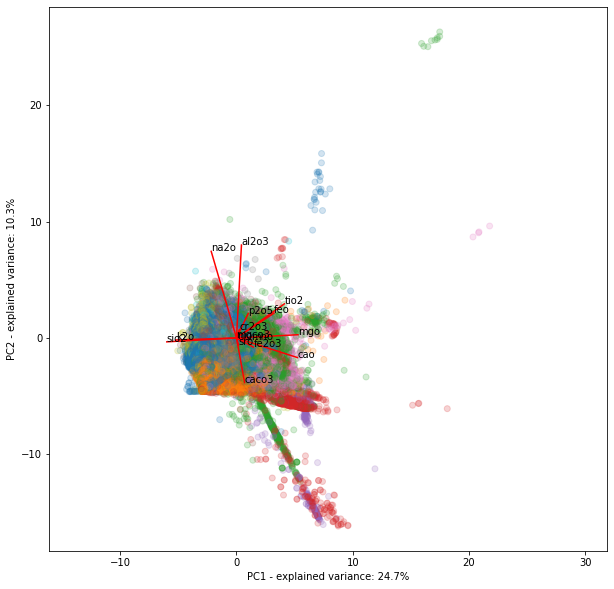

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
pc2plot = (1,2)
ax.scatter(pdat.loc[:, pc2plot[0]-1], pdat.loc[:, pc2plot[1]-1], alpha=0.2, c=["C{}".format(j) for j in y])
ax.axis('equal')
ax.set_xlabel("PC{} - explained variance: {}%".format(pc2plot[0], round(evr[pc2plot[0]-1]*100,1)))
ax.set_ylabel("PC{} - explained variance: {}%".format(pc2plot[1], round(evr[pc2plot[1]-1]*100,1)))

for v, nm in zip(pca.components_[[np.array(pc2plot)-1],:].T, sdat.columns):
  vec = v * 12.5
  ax.plot([0,vec[0]], [0, vec[1]],"r")
  ax.text(vec[0],vec[1], nm)

# Machine Learning Algorithms: Random Forest
* explain decision tree
* under vs over fitting
* random forest as solution to over-fitting
* explain how it works
 * forest/ensemble of imperfect trees better at generalising

## ML models in python
At simplest, all these algorithms have the same usage style in python:

In [ ]:
# We'll discuss this step later
from sklearn import model_selection
xt, xv, yt, yv = model_selection.train_test_split(sdat,y, test_size=0.2)

In [ ]:
# create the model - we'll discuss the parameters later
clf = RandomForestClassifier(max_depth=15, random_state=0, verbose=1, n_jobs=5)

# train the model on input data and corresponding labels
# This step takes some minutes, so we'll let it run while we continue with the explanations
clf.fit(xt, yt)

In [ ]:
# Score the model to assess its accuracy
clf.score(xt, yt)

In [ ]:
# Use the model for prediction
clf.predict(xv)

## Theory: Decision Trees and Random Forest
* Decision trees for classification
 * A hierarchical set of rules to classify from attributes/data

 * Rock classification example:
![](https://www.vagabondgeology.com/uploads/3/4/1/2/3412046/2367852.jpg?895)

  * Can be learnt from the data itself
  * Start with the feature/attribute which best splits the data

* Generalisation and the problem of overfitting
* The solution: Random Forest
 * An ensemble of a large number of deliberately imperfect decision trees.
 * Randomly pick features/attributes at each level of the tree
 * Average results of all the decision trees in the forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from tqdm import tqdm

In [7]:
xt, xv, yt, yv = model_selection.train_test_split(sdat,y, test_size=0.2)

In [70]:
clf = RandomForestClassifier(max_depth=15, random_state=0, verbose=1, n_jobs=5)
clf.fit(xt, yt)

print("train score:", clf.score(xt, yt))
print("test score:", clf.score(xv, yv))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   52.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


train score: 0.8275283448600349


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s


test score: 0.7581193164784651


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


In [97]:

trs = []
tes = []
trees = []
for j in tqdm(range(5,50, 10)):
    trees.append(j)
    
    clf = RandomForestClassifier(max_depth=j, random_state=0, verbose=0, n_jobs=8)
    clf.fit(xt, yt)
    
    trs.append(clf.score(xt, yt))
    tes.append(clf.score(xv, yv))


100%|██████████| 5/5 [05:36<00:00, 67.28s/it]


In [8]:
# for reference for speed
import tensorflow.keras as K

In [21]:
ohy = preprocessing.OneHotEncoder(sparse=False).fit_transform(y.reshape(-1,1))

ohyt = preprocessing.OneHotEncoder(sparse=False).fit_transform(yt.reshape(-1,1))
ohyv = preprocessing.OneHotEncoder(sparse=False).fit_transform(yv.reshape(-1,1))

In [27]:
xt


,sio2,tio2,al2o3,cr2o3,fe2o3,feo,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,caco3,mgco3
77261,-0.682167,-0.460069,-0.086561,-0.023153,-0.507378,-0.728177,0.415457,1.513910,0.216026,-0.005566,-0.902391,-0.349403,-0.016534,-0.237427,-0.045236,0.0
22332,-0.970486,1.130601,-0.164660,-0.023153,-0.507378,-0.728177,0.964549,0.252872,0.012109,-0.005566,0.194233,0.891899,-0.016534,0.780728,-0.045236,0.0
113469,-0.586673,0.714251,-0.176675,-0.023153,-0.507378,1.967198,0.753360,0.753605,0.148054,-0.005566,-0.930949,0.004080,-0.016534,-0.080788,-0.045236,0.0
84333,-0.660130,-0.492095,1.024841,-0.023153,-0.507378,-0.728177,0.491485,0.760969,0.034767,-0.005566,-0.765313,-0.513814,-0.016534,-0.206099,-0.045236,0.0
204311,0.404996,-0.449393,0.481155,-0.023153,-0.507378,-0.728177,-0.617962,-0.369363,-0.146492,-0.005566,-0.182732,1.122074,-0.016534,-0.174771,-0.045236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25940,-0.935594,0.607495,0.529215,-0.023153,0.423037,1.029888,0.421089,0.996608,0.034767,-0.005566,-0.885257,-0.119228,-0.016534,-0.112115,-0.045236,0.0
226112,0.797073,-0.470744,0.339977,-0.023153,-0.507378,-0.728177,-0.736228,-0.588434,-0.146492,-0.005566,0.325599,0.957663,-0.016534,-0.080788,-0.045236,0.0
103168,-0.613301,0.052362,0.309939,-0.023153,-0.507378,1.602958,1.018050,1.059200,-0.327752,-0.005566,-0.948084,-0.439829,-0.016534,-0.206099,-0.045236,0.0
168199,-0.179530,-0.621915,1.111799,-0.023153,-0.507378,-0.728177,-0.141960,-0.122260,-0.035650,-0.005566,-0.631316,0.268071,-0.016534,-0.221991,-0.045236,0.0


In [82]:
del model

In [92]:
model = K.Sequential(
    [K.layers.Dense(64, activation="relu", name="layer1", kernel_initializer='glorot_uniform'),
     K.layers.Dense(64, activation="relu", name="layer2", kernel_initializer='glorot_uniform'),
     K.layers.Dense(64, activation="relu", name="layer3", kernel_initializer='glorot_uniform'),
     K.layers.Dense(14, activation="softmax", name="layerout", kernel_initializer='glorot_uniform')
    ])
opt = K.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=K.losses.SparseCategoricalCrossentropy(from_logits=False), metrics="accuracy")


In [93]:
model.fit(xt, yt, epochs=200, batch_size=600, validation_data=(xv,yv))

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

401/401 [==============================] - 1s 3ms/step - loss: 1.1630 - accuracy: 0.6330 - val_loss: 0.9568 - val_accuracy: 0.6846
Epoch 2/200
401/401 [==============================] - 1s 3ms/step - loss: 0.9343 - accuracy: 0.6886 - val_loss: 0.9016 - val_accuracy: 0.6985
Epoch 3/200
401/401 [==============================] - 1s 3ms/step - loss: 0.8978 - accuracy: 0.6984 - val_loss: 0.8796 - val_accuracy: 0.7048
Epoch 4/200
401/401 [==============================] - 1s 3ms/step - loss: 0.87

In [ ]:
from sklearn.neural_network import MLPClassifier

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(32), verbose=1)
mlp.fit(xt, yt)

print("train score:", mlp.score(xt, yt))
print("test score:", mlp.score(xv, yv))

Iteration 1, loss = 1.23948478
Iteration 2, loss = 1.01773309
Iteration 3, loss = 0.98183757
Iteration 4, loss = 0.96472733
Iteration 5, loss = 0.95317646
Iteration 6, loss = 0.94443722
Iteration 7, loss = 0.93780417
Iteration 8, loss = 0.93222485
Iteration 9, loss = 0.92736871
Iteration 10, loss = 0.92247691
Iteration 11, loss = 0.91835404
Iteration 12, loss = 0.91446164
Iteration 13, loss = 0.91101417
Iteration 14, loss = 0.90798295
Iteration 15, loss = 0.90569154
Iteration 16, loss = 0.90332831
Iteration 17, loss = 0.90153930
Iteration 18, loss = 0.90016536
Iteration 19, loss = 0.89838885
Iteration 20, loss = 0.89695977
Iteration 21, loss = 0.89569243
Iteration 22, loss = 0.89436400
Iteration 23, loss = 0.89350256
Iteration 24, loss = 0.89231364
Iteration 25, loss = 0.89140011
Iteration 26, loss = 0.89064236
Iteration 27, loss = 0.88963729
Iteration 28, loss = 0.88933976
Iteration 29, loss = 0.88793419
Iteration 30, loss = 0.88744577
Iteration 31, loss = 0.88663790
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train score: 0.7128872825991914
test score: 0.7137836847540056


In [13]:
print("train score:", mlp.score(xt, yt))
print("test score:", mlp.score(xv, yv))

train score: 0.7128872825991914
test score: 0.7137836847540056


In [12]:
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=32, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

In [53]:
res = np.argmax(model.predict(xv),axis=1)

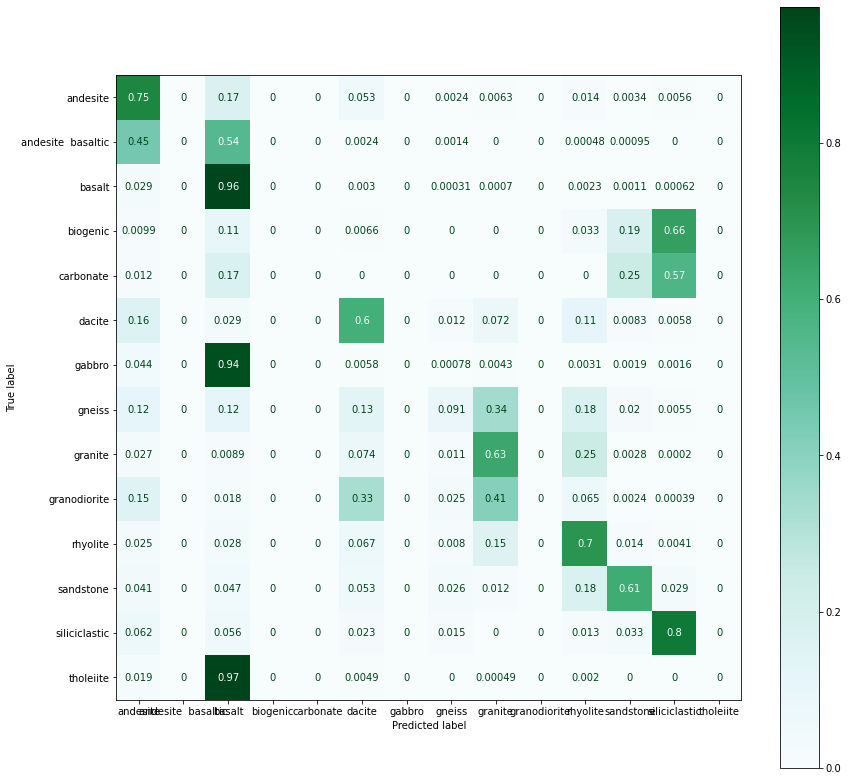

In [66]:
fig, ax = plt.subplots(figsize=(14,14))
ConfusionMatrixDisplay(confusion_matrix(yv, res, normalize="true"), le.classes_).plot(cmap="BuGn",ax=ax)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


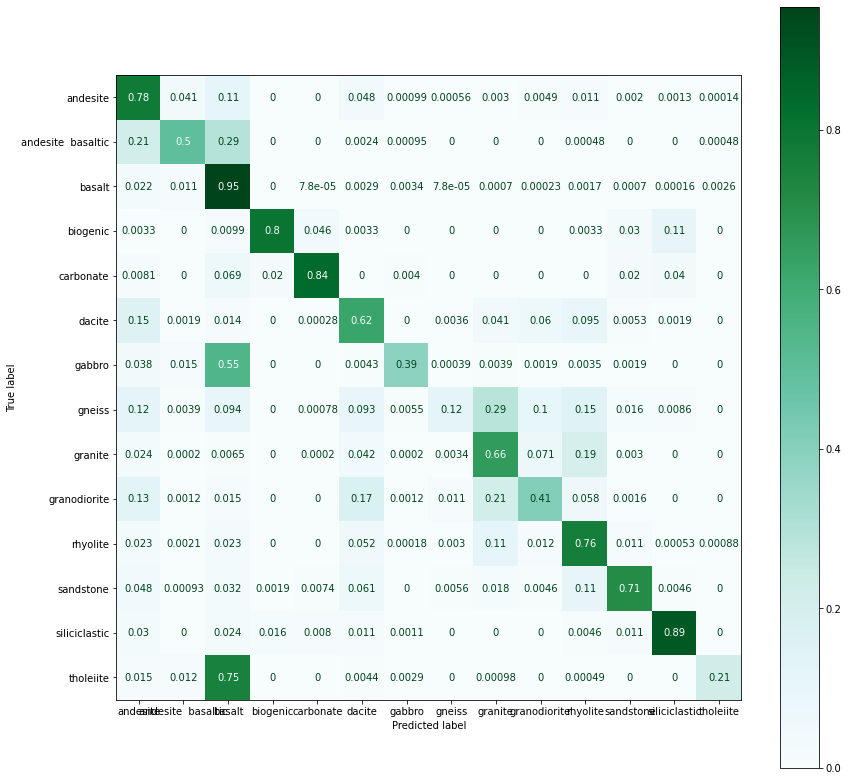

In [71]:
fig, ax = plt.subplots(figsize=(14,14))
plot_confusion_matrix(clf, xv, yv, normalize="true", display_labels=le.classes_, ax=ax, cmap="BuGn")

